In [1]:
from graviz import graph_processing
import networkx as nx
import community as com
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Adding some useful statistics to the nodes in the graph
### If you run from scratch and there are no precomputed files run following cells skip loading graph agian in next section, otherwise start in the next section

In [2]:
#graph = graph_processing.load_graph('graviz/graph.json')

In [3]:
# it takes approximately 10 minutes using 8 cores
#graph, degree_nodes, eigenvector_nodes, betweenness_nodes = graph_processing.add_centrality_stats(graph)

In [4]:
#graph_processing.save_graph(graph, 'graviz/graph_centrality_serialized.json', 'JSON')

# Trimming graph according to eigenvector centrality measure

In [5]:
graph = graph_processing.load_graph('graviz/graph_centrality_serialized.json', 'JSON')
eigenvector_nodes = nx.get_node_attributes(graph, 'eigenvector_centrality')
betweenness_nodes = nx.get_node_attributes(graph, 'betweenness_centrality')

In [6]:
graph = graph_processing.reduce_graph_size(graph, eigenvector_nodes, threshold=2500)

In [7]:
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 2500
Number of edges: 17322
Average degree:  13.8576


In [8]:
parts = com.best_partition(graph)

In [9]:
values = [parts.get(node) for node in graph.nodes()]

In [10]:
nodes_positions = nx.spring_layout(graph)

In [11]:
nodes_positions_mod = nodes_positions
max_label = max(values)

In [12]:
# parameters for community shift
#r = 1
a = 0.6
b = 0.85
for key in nodes_positions_mod:
    # circle or elipse placement
    #nodes_positions_mod[key] += [r/2 * np.cos(2.0 * np.pi * parts[key] / max_label), r * np.sin(2.0 * np.pi * parts[key] / max_label)]
    # logarithmic spiral placement
    nodes_positions_mod[key] += [a * np.exp(b * (1 - parts[key] / max_label)) * np.cos(2.0 * np.pi * (1 - parts[key] / max_label)), a * np.exp(b * (1 - parts[key] / max_label)) * np.sin(2.0 * np.pi * (1 - parts[key] / max_label))]

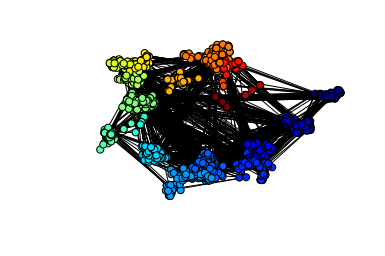

In [13]:
plt.axis("off")
nx.draw_networkx(graph, pos=nodes_positions_mod, cmap = plt.get_cmap("jet"), node_color = values, node_size = 50, with_labels = False)